In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

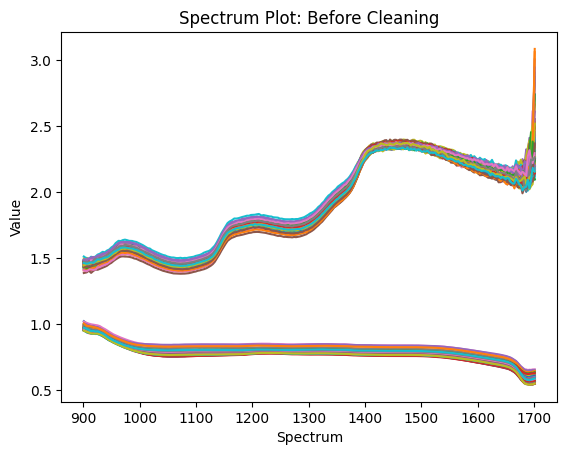

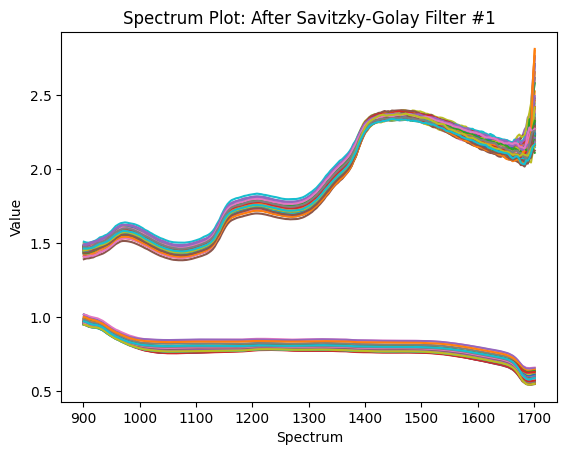

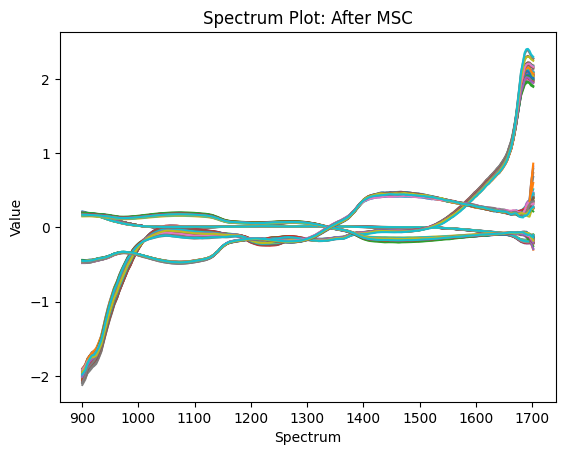

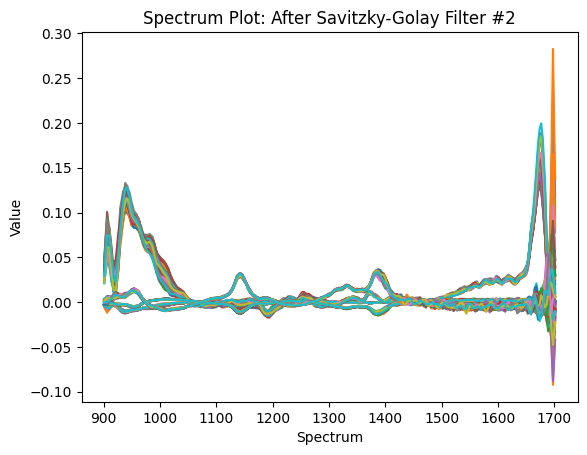

(200, 228) (200,)
-1.2732740374102107
    y_test    y_pred
0   3.7925  3.167429
1   4.3785  3.398643
2   3.9805  8.221049
3   4.3405  4.242576
4   6.9380  3.808403
5   4.8185  2.783703
6   1.0700  2.325023
7   3.4905  5.105103
8   3.1780  3.790642
9   4.1585  3.466917
10  3.5540  2.590217
11  5.9360  3.663629
12  4.2140  3.468639
13  3.8070  3.821029
14  5.0340  2.916003
15  4.7610  3.545301
16  3.9965  4.108612
17  3.9635  3.727306
18  3.6910  3.951775
19  4.0705  3.804809
20  3.4215  2.556451
21  3.2460  2.423386
22  3.7260  4.283903
23  4.0580  5.530227
24  3.2090  3.530765
25  3.8350  3.110658
26  4.3245  3.288142
27  3.4180  2.906618
28  4.2875  2.613971
29  3.3930  3.121570
30  4.0195  3.667559
31  3.6580  5.741685
32  4.1760  3.423727
33  3.7940  3.743156
34  3.9855  3.887506
35  3.3620  2.242307
36  3.7780  3.593749
37  2.9350  3.609493
38  3.4120  3.113716
39  4.0315  3.749013


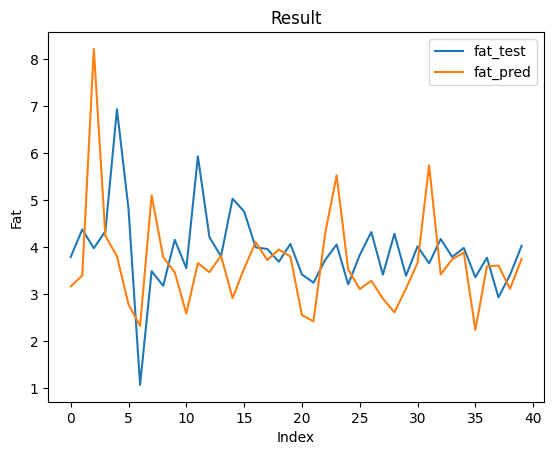

In [2]:
#Data Manipulation
data = pd.read_excel('dataset.xlsx', index_col=0)
y_names = data.columns[0:6]
spectrum = data.columns[6:]
def split_data_corr_y(data):
    dataset_dict = {}
    for name in y_names:
        temp_data = data
        y_data = data[name]
        temp_data = temp_data.drop(columns=y_names)
        temp_data[name] = y_data
        dataset_dict[name] = temp_data
    return dataset_dict
def plot_spectrum(title):
    fig = plt.figure()
    ax = fig.subplots()
    for index in data.index:
        p = ax.plot(data.loc[index,spectrum])
    plt.title(title)
    plt.xlabel('Spectrum')
    plt.ylabel('Value')
    plt.show()
plot_spectrum('Spectrum Plot: Before Cleaning')
def perform_savgol(pol, wl, dvt):
    for index in data.index:
        data.loc[index,spectrum] = savgol_filter(data.loc[index,spectrum], polyorder=pol, window_length=wl, deriv=dvt, mode='nearest')
#Savitzky-Golay Filter : polynomial order = 1 window_length = 15 derivative = 0
perform_savgol(1,3,0)
plot_spectrum('Spectrum Plot: After Savitzky-Golay Filter #1')
def msc(input_data, reference=None):
    """
        :msc: Scatter Correction technique performed with mean of the sample data as the reference.
        :param input_data: Array of spectral data
        :type input_data: DataFrame
        :returns: data_msc (ndarray): Scatter corrected spectra data
    """
    eps = np.finfo(np.float32).eps
    input_data = np.array(input_data, dtype=np.float64)
    ref = []
    sampleCount = int(len(input_data))

    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    
    # Get the reference spectrum. If not given, estimate it from the mean
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        for j in range(0, sampleCount, 10):
            ref.append(np.mean(input_data[j:j+10], axis=0))
            # Run regression
            fit = np.polyfit(ref[i], input_data[i,:], 1, full=True)
            # Apply correction
            data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0]
    
    return (data_msc)
data.loc[:,spectrum] = msc(data.loc[:,spectrum])
plot_spectrum('Spectrum Plot: After MSC')
#Savitzky-Golay Filter : polynomial order = 2 window_length = 21  derivative = 1
perform_savgol(1,3,1)
plot_spectrum('Spectrum Plot: After Savitzky-Golay Filter #2')
#split individual y(s)
dataset_dict = split_data_corr_y(data)
#training preprocess
data_to_train = dataset_dict.get('fat') #use specific feature to train
X = data_to_train.iloc[:,:-1].to_numpy()
y = data_to_train.iloc[:,-1].to_numpy()
print(X.shape,y.shape)
#train-test split
data_to_train = dataset_dict.get('fat')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#normalize y
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.reshape(-1,1))
y_test = scaler.transform(y_test.reshape(-1,1))
model = PLSRegression(n_components=20)
model.fit(x_train, y_train)
#regression score
score = model.score(x_test, y_test)
print(score)
#predict
y_pred = model.predict(x_test)
#compare values
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)
compare = pd.DataFrame(columns=['y_test','y_pred'])
compare['y_test'] = y_test.reshape(len(y_test),)
compare['y_pred'] = y_pred.reshape(len(y_pred),)
print(compare)
fig2 = plt.figure()
ax = fig2.subplots()
p = ax.plot(compare['y_test'])
p = ax.plot(compare['y_pred'])
plt.legend(['fat_test', 'fat_pred'])
plt.title('Result')
plt.xlabel('Index')
plt.ylabel('Fat')
plt.show()